# Hoja de Trabajo \# 5


---


por Josué Obregón <br>
DS6011 - Feature Engineering <br>
UVG Masters - Escuela de Negocios<br>


## Objetivos

El objetivo de esta hoja de trabajo  es presentar al estudiante diferentes técnicas de extracción y generación de atributos.

También se busca que el estudiante practique la utilización de éstas técnicas con las librerías disponibles en el lenguaje Python.

## Importación de librerías y carga de los datos

Las librerías que importaremos para empezar son pandas y numpy para el manejo de los datos, y matplotlib, seaborn y plotly para la generación de visualizaciones. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Dimensionality reduction

## Ejemplo con datos de prueba

In [2]:
df_test = pd.DataFrame({
... 'Gene1': [10,11,8,3,2,1],
... 'Gene2': [6,4,5,3,2.8,1],
... 'Gene3': [12,9,10,2.5,1.3,2],
... 'Gene4': [5,7,6,2,4,7]
... }, index=['Mouse1','Mouse2','Mouse3','Mouse4','Mouse5','Mouse6'])

In [3]:
df_test

,Gene1,Gene2,Gene3,Gene4
Mouse1,10,6.0,12.0,5
Mouse2,11,4.0,9.0,7
Mouse3,8,5.0,10.0,6
Mouse4,3,3.0,2.5,2
Mouse5,2,2.8,1.3,4
Mouse6,1,1.0,2.0,7


<Axes: xlabel='Gene1', ylabel='Gene2'>

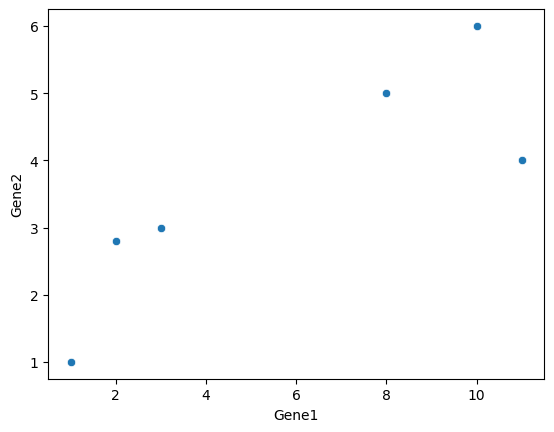

In [4]:
sns.scatterplot(data=df_test,  x='Gene1',y='Gene2')

### PCA

In [5]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA()

In [21]:
pca.fit(df_test)

PCA()

In [22]:
pca_proj = pd.DataFrame(pca.transform(df_test), columns=['Component1','Component2','Component3','Component4'], index = df_test.index) #

In [23]:
pca_proj

,Component1,Component2,Component3,Component4
Mouse1,7.435167,-1.157951,-0.885242,-0.039570
Mouse2,5.696298,1.510140,1.917896,-0.033484
Mouse3,4.582350,0.182406,-1.077132,0.127922
Mouse4,-4.935668,-2.625896,0.508698,-0.377957
Mouse5,-6.264743,-0.673880,0.321437,0.553774
Mouse6,-6.513403,2.765180,-0.785657,-0.230685


In [24]:
df_test


,Gene1,Gene2,Gene3,Gene4
Mouse1,10,6.0,12.0,5
Mouse2,11,4.0,9.0,7
Mouse3,8,5.0,10.0,6
Mouse4,3,3.0,2.5,2
Mouse5,2,2.8,1.3,4
Mouse6,1,1.0,2.0,7


In [25]:
pca.components_

array([[ 0.65105257,  0.23955265,  0.71150241,  0.11184542],
       [ 0.00166297, -0.3750331 , -0.02093861,  0.92677342],
       [ 0.75901752, -0.20980962, -0.60817046, -0.10000505],
       [ 0.00449286,  0.87060015, -0.35136104,  0.34435536]])

In [19]:
pca.explained_variance_ratio_

array([0.89284793, 0.07753734])

In [26]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

<Axes: xlabel='Component1', ylabel='Component2'>

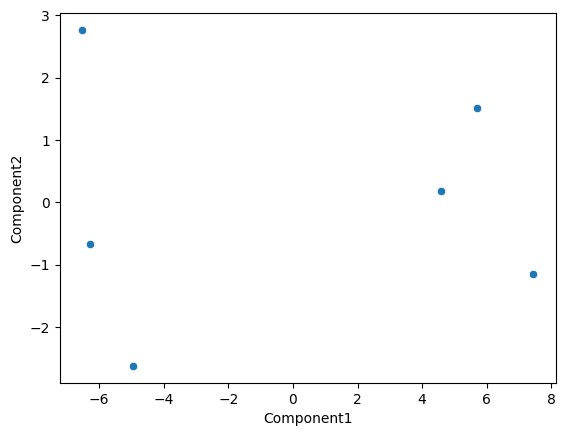

In [27]:
sns.scatterplot(data=pca_proj,  x='Component1',y='Component2')

<Axes: xlabel='Component2', ylabel='Component3'>

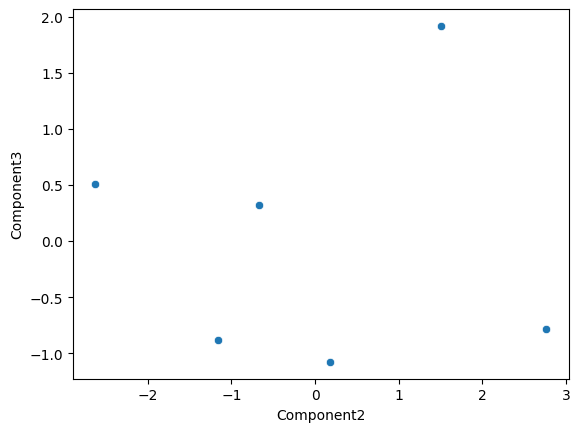

In [28]:
sns.scatterplot(data=pca_proj,  x='Component2',y='Component3')

### NMF

In [29]:
from sklearn.decomposition import NMF

In [30]:
nmf = NMF(n_components=2)

In [31]:
nmf.fit(df_test)

NMF(n_components=2)

In [32]:
nmf_proj = pd.DataFrame(nmf.transform(df_test), columns=['Component1','Component2'], index = df_test.index)

In [33]:
nmf_proj

,Component1,Component2
Mouse1,0.398391,1.490266
Mouse2,1.179418,1.222209
Mouse3,0.954551,1.159240
Mouse4,0.373067,0.384430
Mouse5,1.163224,0.162742
Mouse6,2.135971,0.000000


In [49]:
pca_proj

,Component1,Component2,Component3,Component4
Mouse1,7.435167,-1.157951,-0.885242,-0.039570
Mouse2,5.696298,1.510140,1.917896,-0.033484
Mouse3,4.582350,0.182406,-1.077132,0.127922
Mouse4,-4.935668,-2.625896,0.508698,-0.377957
Mouse5,-6.264743,-0.673880,0.321437,0.553774
Mouse6,-6.513403,2.765180,-0.785657,-0.230685


<Axes: xlabel='Component1', ylabel='Component2'>

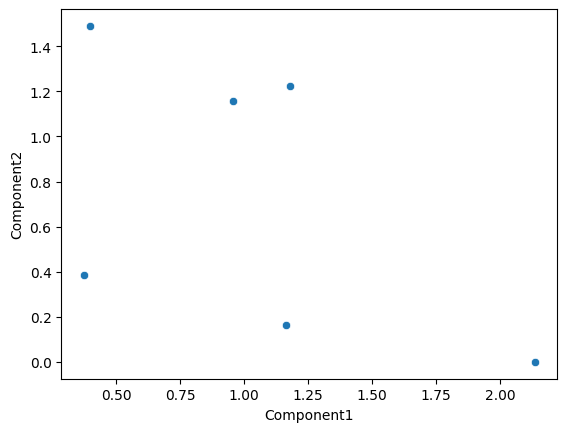

In [50]:
sns.scatterplot(data=nmf_proj,  x='Component1',y='Component2')

In [51]:
print('Dimensiones de los datos proyectados: ',nmf_proj.shape)
print('Dimensiones de la matriz H: ', nmf.components_.shape)

Dimensiones de los datos proyectados:  (6, 2)
Dimensiones de la matriz H:  (2, 4)


In [36]:
  # X ≈ W x H
np.matmul(nmf_proj.to_numpy(),nmf.components_)

array([[10.73346572,  5.63871885, 11.47985872,  5.02704818],
       [ 9.38233306,  5.21444676,  9.96496745,  6.88816439],
       [ 8.78742093,  4.83225307,  9.34571582,  6.00108175],
       [ 2.9525186 ,  1.64158833,  3.13570637,  2.17338147],
       [ 1.93312562,  1.39049901,  1.97589085,  4.18031933],
       [ 1.45167326,  1.47787714,  1.37776656,  6.9271514 ]])

In [52]:
df_test

,Gene1,Gene2,Gene3,Gene4
Mouse1,10,6.0,12.0,5
Mouse2,11,4.0,9.0,7
Mouse3,8,5.0,10.0,6
Mouse4,3,3.0,2.5,2
Mouse5,2,2.8,1.3,4
Mouse6,1,1.0,2.0,7


# Ejemplo con los datos de pasajeros en Chicago

In [38]:
!mkdir data

In [39]:
import gdown

urls = ['https://drive.google.com/uc?export=download&id=1QvHTL7yok7oHX0TmuSm8OMpvxnItjT_s', # training  https://drive.google.com/file/d/1QvHTL7yok7oHX0TmuSm8OMpvxnItjT_s/view?usp=sharing  
        'https://drive.google.com/uc?export=download&id=1nWcvoCkgUeCr-AT45JSsqKcSBUr1YbpU', # testing https://drive.google.com/file/d/1nWcvoCkgUeCr-AT45JSsqKcSBUr1YbpU/view?usp=sharing
        'https://drive.google.com/uc?export=download&id=1LIK0YFER5ve9Wn7Uap4Zb6f5pXcAExZ-', # train_days   https://drive.google.com/file/d/1LIK0YFER5ve9Wn7Uap4Zb6f5pXcAExZ-/view?usp=sharing 
        'https://drive.google.com/uc?export=download&id=16AGQw1nM9NYILv2aSZaSNSn9jBPByWPq', # okc_train  https://drive.google.com/file/d/16AGQw1nM9NYILv2aSZaSNSn9jBPByWPq/view?usp=sharing
        ]
outputs = ['training_proj.csv','testing_proj.csv', 'train_days.csv','okc_train.csv']

for url,output in zip(urls,outputs):
  gdown.download(url, f'data/{output}', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1QvHTL7yok7oHX0TmuSm8OMpvxnItjT_s
To: /content/data/training_proj.csv
100%|██████████| 35.2M/35.2M [00:00<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1nWcvoCkgUeCr-AT45JSsqKcSBUr1YbpU
To: /content/data/testing_proj.csv
100%|██████████| 101k/101k [00:00<00:00, 52.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1LIK0YFER5ve9Wn7Uap4Zb6f5pXcAExZ-
To: /content/data/train_days.csv
100%|██████████| 107k/107k [00:00<00:00, 71.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=16AGQw1nM9NYILv2aSZaSNSn9jBPByWPq
To: /content/data/okc_train.csv
100%|██████████| 12.3M/12.3M [00:00<00:00, 14.4MB/s]


In [40]:
training = pd.read_csv('data/training_proj.csv', parse_dates=True, index_col=0)
testing = pd.read_csv('data/testing_proj.csv', parse_dates=True, index_col=1)
train_days = pd.read_csv('data/train_days.csv',index_col=1, parse_dates=True)

In [41]:
training.head()

,s_40380,dow,doy,week,month,year,Advent1st,Advent2nd,Advent3rd,Advent4th,...,Bulls_Away,Bulls_Home,Bears_Away,Bears_Home,WhiteSox_Away,WhiteSox_Home,Cubs_Away,Cubs_Home,l14_gas_price,l30_unemployment_rate
1,15.732,Mon,22,4,Jan,2001,0,0,0,0,...,0,0,0,0,0,0,0,0,1.516,NaN
2,15.762,Tue,23,4,Jan,2001,0,0,0,0,...,0,1,0,0,0,0,0,0,1.516,NaN
3,15.872,Wed,24,4,Jan,2001,0,0,0,0,...,1,0,0,0,0,0,0,0,1.516,NaN
4,15.874,Thu,25,4,Jan,2001,0,0,0,0,...,0,0,0,0,0,0,0,0,1.516,NaN
5,15.423,Fri,26,4,Jan,2001,0,0,0,0,...,0,0,0,0,0,0,0,0,1.516,NaN


In [54]:
training.shape

(5698, 1091)

In [42]:
testing

,Unnamed: 0,s_40380,dow,doy,week,month,year,Advent1st,Advent2nd,Advent3rd,...,Bulls_Away,Bulls_Home,Bears_Away,Bears_Home,WhiteSox_Away,WhiteSox_Home,Cubs_Away,Cubs_Home,l14_gas_price,l30_unemployment_rate
date,,,,,,,,,,,,,,,,,,,,,
2016-08-29,1,21.137,Mon,242,35,Aug,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.380,5.8
2016-08-30,2,21.464,Tue,243,35,Aug,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.380,5.8
2016-08-31,3,21.738,Wed,244,35,Aug,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.380,5.8
2016-09-01,4,21.482,Thu,245,35,Sep,2016,0,0,0,...,0,0,1,0,1,1,1,1,2.380,5.8
2016-09-02,5,19.790,Fri,246,36,Sep,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.479,5.8
2016-09-03,6,6.906,Sat,247,36,Sep,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.479,5.8
2016-09-04,7,6.196,Sun,248,36,Sep,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.479,5.8
2016-09-05,8,5.832,Mon,249,36,Sep,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.479,5.8
2016-09-06,9,21.117,Tue,250,36,Sep,2016,0,0,0,...,0,0,0,0,1,1,1,1,2.479,5.8


In [55]:
testing.shape

(14, 1092)

In [43]:
weekends = training[training['dow'].isin(['Sat','Sun'])].filter(regex=("(l14_[0-9]|s_40380)"), axis=1).copy()
print(weekends.to_numpy().shape)
weekends.head()

(1628, 126)


,s_40380,l14_40010,l14_40020,l14_40030,l14_40040,l14_40050,l14_40060,l14_40070,l14_40080,l14_40090,...,l14_41400,l14_41410,l14_41420,l14_41440,l14_41450,l14_41460,l14_41480,l14_41490,l14_41500,l14_41660
6,2.425,0.693,1.610,0.889,0.911,2.704,2.274,1.954,2.733,0.994,...,3.370,0.661,3.079,0.662,9.386,0.953,1.646,1.367,0.912,5.605
7,1.467,0.408,0.882,0.601,0.414,1.468,1.631,0.978,1.843,0.565,...,2.292,0.389,2.170,0.270,6.490,0.486,0.909,0.887,0.567,3.662
13,2.477,0.663,1.640,0.880,0.914,2.422,2.280,1.852,2.675,1.046,...,3.105,0.635,2.863,0.642,9.332,0.932,1.582,1.204,0.949,5.734
14,1.556,0.411,0.873,0.580,0.454,1.471,1.639,1.015,1.821,0.533,...,2.183,0.371,2.025,0.312,6.016,0.488,0.920,0.661,0.491,3.759
20,2.432,0.677,1.729,0.929,0.914,2.573,2.317,1.820,2.550,1.058,...,3.138,0.719,2.922,0.634,9.301,0.883,1.642,1.048,0.905,6.104


In [44]:
weekend_days = train_days[train_days.index.dayofweek>4].copy()
print(weekend_days.index[0])
print(weekend_days.index[-1])
print(len(weekend_days))

2001-01-27 00:00:00
2016-08-28 00:00:00
1628


Utilizaremos a manera de ejemplo una librería para validación de series de tiempo [tscv](https://github.com/WenjieZ/TSCV) [Artículo informativo](https://www.zhengwenjie.net/tscv/)

In [45]:
!pip install tscv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from tscv import GapRollForward

In [47]:
ts_cv= GapRollForward(min_train_size=1600,min_test_size=4,max_test_size= 4,roll_size=1)

In [48]:
i=1
for train_index, test_index in ts_cv.split( weekend_days):
  print(f'Training Split {i}: {train_index.shape} -- Testing Split {i}: {test_index.shape}')
  i=i+1
  # print(train_index[0])
  # print(train_index[-1])
  # print(test_index[0])
  # print(test_index[-1])


Training Split 1: (1600,) -- Testing Split 1: (4,)
Training Split 2: (1601,) -- Testing Split 2: (4,)
Training Split 3: (1602,) -- Testing Split 3: (4,)
Training Split 4: (1603,) -- Testing Split 4: (4,)
Training Split 5: (1604,) -- Testing Split 5: (4,)
Training Split 6: (1605,) -- Testing Split 6: (4,)
Training Split 7: (1606,) -- Testing Split 7: (4,)
Training Split 8: (1607,) -- Testing Split 8: (4,)
Training Split 9: (1608,) -- Testing Split 9: (4,)
Training Split 10: (1609,) -- Testing Split 10: (4,)
Training Split 11: (1610,) -- Testing Split 11: (4,)
Training Split 12: (1611,) -- Testing Split 12: (4,)
Training Split 13: (1612,) -- Testing Split 13: (4,)
Training Split 14: (1613,) -- Testing Split 14: (4,)
Training Split 15: (1614,) -- Testing Split 15: (4,)
Training Split 16: (1615,) -- Testing Split 16: (4,)
Training Split 17: (1616,) -- Testing Split 17: (4,)
Training Split 18: (1617,) -- Testing Split 18: (4,)
Training Split 19: (1618,) -- Testing Split 19: (4,)
Training Sp

In [56]:
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py 
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 25
def plot_cv_indices(cv, X, y,  ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        x_labels = [weekend_days.index[idx].strftime('%Y-%m-%d') for idx in range(len(indices))]        
       #print(len(x_labels))
       # print(len([ii + .5] * len(indices)))
        ax.scatter(x_labels, [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits)) 
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
             xlim=[1585, 1630])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    plt.xticks(rotation='vertical')
    return ax

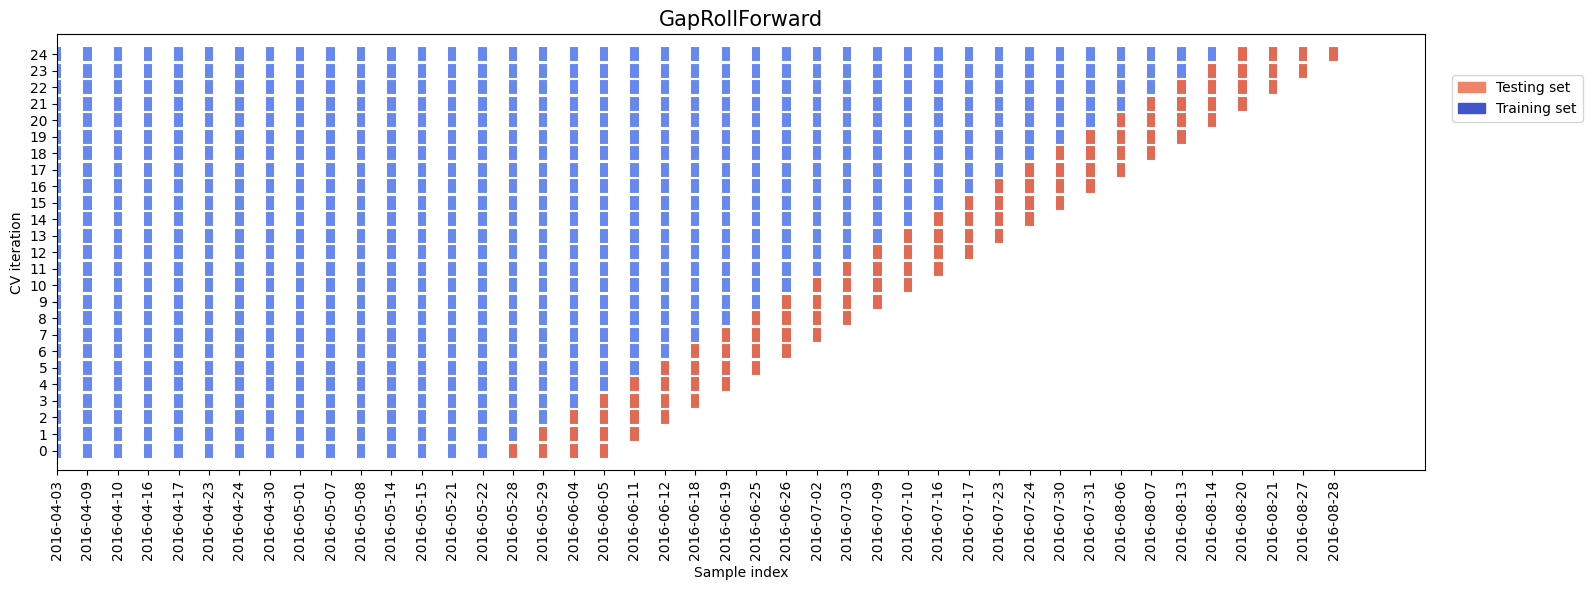

In [57]:
groups = np.hstack([[ii] * 25 for ii in range(25)])
fig, ax = plt.subplots(figsize=(16, 6))
plot_cv_indices(ts_cv, weekends, None,  ax, n_splits)

ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
# Make the legend fit
plt.tight_layout()

In [58]:
X_train = weekends.drop(['s_40380'],axis=1) # Variables predictoras X
X_train.head()

,l14_40010,l14_40020,l14_40030,l14_40040,l14_40050,l14_40060,l14_40070,l14_40080,l14_40090,l14_40100,...,l14_41400,l14_41410,l14_41420,l14_41440,l14_41450,l14_41460,l14_41480,l14_41490,l14_41500,l14_41660
6,0.693,1.610,0.889,0.911,2.704,2.274,1.954,2.733,0.994,3.023,...,3.370,0.661,3.079,0.662,9.386,0.953,1.646,1.367,0.912,5.605
7,0.408,0.882,0.601,0.414,1.468,1.631,0.978,1.843,0.565,2.195,...,2.292,0.389,2.170,0.270,6.490,0.486,0.909,0.887,0.567,3.662
13,0.663,1.640,0.880,0.914,2.422,2.280,1.852,2.675,1.046,3.104,...,3.105,0.635,2.863,0.642,9.332,0.932,1.582,1.204,0.949,5.734
14,0.411,0.873,0.580,0.454,1.471,1.639,1.015,1.821,0.533,2.171,...,2.183,0.371,2.025,0.312,6.016,0.488,0.920,0.661,0.491,3.759
20,0.677,1.729,0.929,0.914,2.573,2.317,1.820,2.550,1.058,3.110,...,3.138,0.719,2.922,0.634,9.301,0.883,1.642,1.048,0.905,6.104


In [59]:
y_train = weekends['s_40380'] # Variable respuesta Y
y_train.head()

6     2.425
7     1.467
13    2.477
14    1.556
20    2.432
Name: s_40380, dtype: float64

### Baseline con regresión lineal

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline

In [64]:
lr = LinearRegression()

In [65]:
cross_val  = cross_val_score( lr, X_train, y_train, cv=ts_cv, scoring='neg_root_mean_squared_error')
print(cross_val*-1)
print(f'Mean: {cross_val.mean()*-1}, Std: {cross_val.std()}')

[0.72689689 0.78765332 0.70486282 0.76826587 0.77764362 0.57708818
 0.73809462 0.70769294 0.72473128 0.71359768 0.76220357 0.75457878
 0.69509936 0.58001822 0.57824242 0.5716051  0.59847844 0.66711076
 0.52862888 0.67875962 0.68095314 0.59486706 1.02346851 1.00033777
 0.95691412]
Mean: 0.7159117184517422, Std: 0.12589588137729457


### PCA

In [ ]:
pca_stations = PCA(n_components=20,random_state=6011)

In [ ]:
pca_stations.fit(X_train)

In [ ]:
print(pca_stations.n_components_)
print(pca_stations.components_.shape) #eigenvectors

In [ ]:
variance_ration_cumsum = np.cumsum(np.pad(pca_stations.explained_variance_ratio_, (1, 0), "constant"))
variance_ration_cumsum

In [ ]:
fig =px.line(x=range(21), y=variance_ration_cumsum, width=500, height=500)
fig.update_yaxes(range=[-0.02, 1.02])

In [ ]:
projected_pca_stations = pca_stations.transform(X_train)
projected_pca_stations = pd.DataFrame(projected_pca_stations, columns=[f'Component{i+1}' for i in range(20)])
projected_pca_stations.head()

In [ ]:
from plotly.subplots import make_subplots

In [ ]:
#fig, axes = plt.subplots( nrows=5,n_cols=1)
fig = make_subplots( rows=1, cols=5, subplot_titles=[f'Component{i+1}' for i in range(5)],
                    column_widths=[50 for i in range(5)], row_heights=[50 ])
for i in range(1,6):
  scat = px.scatter( data_frame=projected_pca_stations, x=f'Component{i}', 
  y=y_train, color_discrete_sequence=['black'], opacity=0.3,
   trendline='ols' )
  fig.add_trace(scat.data[0], col=i, row=1)
  fig.add_trace(scat.data[1], col=i, row=1)
fig.update_layout(
    height=300, width=1500,
    margin=dict(l=5, r=5, t=30, b=5),
)
fig.show()

## NMF

In [ ]:
nfm_stations = NMF(n_components=20, random_state=6011)

In [ ]:
nfm_stations.fit(X_train)

In [ ]:
nfm_stations.reconstruction_err_

In [ ]:
projected_nfm_stations = nfm_stations.transform(X_train)
projected_nfm_stations = pd.DataFrame(projected_nfm_stations, columns=[f'Component{i+1}' for i in range(20)])
projected_nfm_stations.head()

In [ ]:
#fig, axes = plt.subplots( nrows=5,n_cols=1)
fig = make_subplots( rows=1, cols=15, subplot_titles=[f'Component{i+1}' for i in range(15)],
                    column_widths=[50 for i in range(15)], row_heights=[50 ])
for i in range(1,15):
  scat = px.scatter( data_frame=projected_nfm_stations, x=f'Component{i}', 
  y=y_train, color_discrete_sequence=['black'], opacity=0.3,
   trendline='ols' )
  fig.add_trace(scat.data[0], col=i, row=1)
  fig.add_trace(scat.data[1], col=i, row=1)
fig.update_layout(
    height=300, width=2500,
    margin=dict(l=5, r=5, t=30, b=5),
)
fig.show()

## PLS

In [ ]:
from sklearn.cross_decomposition import PLSCanonical,PLSRegression

In [ ]:
pls_stations = PLSRegression(n_components=20 )

In [ ]:
pls_stations.fit(X_train,y_train)

In [ ]:
pls_stations.x_scores_

In [ ]:
projected_pls_stations = pls_stations.transform(X_train)
projected_pls_stations = pd.DataFrame(projected_pls_stations, columns=[f'Component{i+1}' for i in range(20)])
projected_pls_stations.head()

In [ ]:
#fig, axes = plt.subplots( nrows=5,n_cols=1)
fig = make_subplots( rows=1, cols=5, subplot_titles=[f'Component{i+1}' for i in range(5)],
                    column_widths=[50 for i in range(5)], row_heights=[50 ])
for i in range(1,6):

  #PLS
  scat3 = px.scatter( data_frame=projected_pls_stations, x=f'Component{i}', 
  y=y_train, color_discrete_sequence=['black'], opacity=0.3,
   trendline='ols' )
  fig.add_trace(scat3.data[0], col=i, row=1)
  fig.add_trace(scat3.data[1], col=i, row=1)
fig.update_layout(
    height=300, width=1200,
    margin=dict(l=5, r=5, t=30, b=5),
)
fig.show()

### Gráfica de resumen

In [ ]:
#fig, axes = plt.subplots( nrows=5,n_cols=1)
fig = make_subplots( rows=5, cols=3, row_titles=[f'Component{i+1}' for i in range(5)],
                     horizontal_spacing=0.01, vertical_spacing=0.01,  shared_xaxes=True,
                     column_titles=['PCA', 'NFM', 'PLS'])
for i in range(1,6):
  #PCA
  scat = px.scatter( data_frame=projected_pca_stations, x=f'Component{i}', 
  y=y_train, color_discrete_sequence=['black'], opacity=0.3,
   trendline='ols' )
  fig.add_trace(scat.data[0], col=1, row=i)
  fig.add_trace(scat.data[1], col=1, row=i)

  #NMF
  scat2 = px.scatter( data_frame=projected_nfm_stations, x=f'Component{i}', 
  y=y_train, color_discrete_sequence=['black'], opacity=0.3,
   trendline='ols' )
  fig.add_trace(scat2.data[0], col=2, row=i)
  fig.add_trace(scat2.data[1], col=2, row=i)

  #PLS
  scat = px.scatter( data_frame=projected_pls_stations, x=f'Component{i}', 
  y=y_train, color_discrete_sequence=['black'], opacity=0.3,
   trendline='ols' )
  fig.add_trace(scat.data[0], col=3, row=i)
  fig.add_trace(scat.data[1], col=3, row=i)
fig.update_layout(
    height=900, width=700,
    margin=dict(l=5, r=20, t=40, b=5),
)
fig.show()

## Comparando el rendimiento

In [ ]:
pca_lr_pipe = Pipeline([('pca', PCA(n_components=20,random_state=6011)),
                   ('lr', LinearRegression())])

cross_val_pca  = cross_val_score(pca_lr_pipe, X_train, y_train, cv=ts_cv, scoring='neg_root_mean_squared_error')
print(cross_val_pca*-1)
print('=================================================')
print('Resultado de la regresión lineal utilizando PCA')
print(f'Media: {cross_val_pca.mean()*-1}, Std: {cross_val_pca.std()}')

In [ ]:
nmf_lr_pipe = Pipeline([('nmf', NMF(n_components=20,random_state=6011)),
                   ('lr', LinearRegression())])

cross_val_nmf  = cross_val_score(nmf_lr_pipe, X_train, y_train, cv=ts_cv, scoring='neg_root_mean_squared_error')
print(cross_val_nmf*-1)
print('=================================================')
print('Resultado de la regresión lineal utilizando NMF')
print(f'Media: {cross_val_nmf.mean()*-1}, Std: {cross_val_nmf.std()}')

In [ ]:
from sklearn.cross_decomposition import PLSRegression

In [ ]:
pls_lr_pipe = Pipeline([('pls', PLSRegression(n_components=20)),])

cross_val_pls  = cross_val_score(pls_lr_pipe, X_train, y_train, cv=ts_cv, scoring='neg_root_mean_squared_error')
print(cross_val_pls*-1)
print('=================================================')
print('Resultado de la regresión lineal utilizando PLS')
print(f'Media: {cross_val_pls.mean()*-1}, Std: {cross_val_pls.std()}')

In [ ]:
comp_df = pd.DataFrame()
comp_df['RMSE'] = np.concatenate([cross_val_pca,cross_val_nmf,cross_val_pls], axis=0)
comp_df['RMSE'] = comp_df['RMSE'] * -1
comp_df['Algorithm'] = np.concatenate([['PCA']*25,['NMF']*25,['PLS']*25], axis=0)
comp_df.head()

In [ ]:
px.box(data_frame=comp_df, x='RMSE', y ='Algorithm', orientation='h', width=600, height=400, notched=True )

# Feature Interactions

## Polinomyal interactions or combinations

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X_poly = pd.DataFrame(np.arange(6).reshape(3,2),columns=['x1','x2'])
X_poly

In [ ]:
poly = PolynomialFeatures(3) # interaction_only=False, include_bias=True,

In [ ]:
poly_generated = poly.fit_transform(X_poly)
poly_generated = pd.DataFrame(poly_generated, columns=poly.get_feature_names_out())
poly_generated

## Feature crossing

Para esta funcionalidad utilizaremos el paquete [patsy](https://patsy.readthedocs.io/en/latest/overview.html) de python para describir modelos estadísticos y construir matrices de diseño (design matrices)

In [ ]:
from patsy import dmatrices, dmatrix

In [ ]:
df_okc = pd.read_csv('data/okc_train.csv',index_col=0)
df_okc.head()

$a * b$ es una abreviación de  $a + b + a:b$, y es útil para el caso común donde se desea incluir todas las interaccones entre las variables 


In [ ]:
y_cross,X_cross = dmatrices('Class~C(drinks)*C(drugs)', data=df_okc,return_type='dataframe') # a * b is short-hand for a + b + a:b

In [ ]:
X_cross.head()

In [ ]:
y_cross.head()

In [ ]:
X_cross = dmatrix('C(drinks)*C(drugs)', data=df_okc,return_type='dataframe')

In [ ]:
X_cross.head()

# Non linear Featurization

## K-means featurization

Este ejemplo es parte del capítulo 7 del libro [Feature Engineering for Machine Learning](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/). El link con el código original está en el [github del libro](https://github.com/alicezheng/feature-engineering-book/blob/master/07.03-05_K-means_featurization.ipynb).

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1)) # crea una columna binaria por cada cluster
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, 
                                   n_init=20, 
                                   random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:2], 
                          n_init=1, 
                          max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
seed = 6011
training_data, training_labels = make_moons(n_samples=2000, noise=0.2, random_state=seed)

In [ ]:
training_data

In [ ]:
training_labels

In [ ]:
 plt.scatter(training_data[:, 0], training_data[:, 1], c=training_labels, cmap='Set1', alpha=0.2)

In [ ]:
kmf_hint = KMeansFeaturizer(k=100, target_scale=10, random_state=seed).fit(training_data, training_labels)
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0, random_state=seed).fit(training_data, training_labels)

In [ ]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the kmeans clusters overlayed with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

In [ ]:
fig = plt.figure(figsize=(24,10))
ax = plt.subplot(211, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax)
ax.set_title('K-Means with Target Hint')
ax2 = plt.subplot(212, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax2.set_title('K-Means without Target Hint')

## Classification with KMeans clustering features¶

In [ ]:
test_data, test_labels = make_moons(n_samples=2000, noise=0.3, random_state=seed+5)

In [ ]:
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

training_with_cluster = hstack((training_data, training_cluster_features)) #scipy.sparse.hstack
test_with_cluster = hstack((test_data, test_cluster_features))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster, training_labels)

classifier_names = ['LR',
                    'kNN',
                    'RBF SVM',
                    'Random Forest',
                    'Boosted Trees']
classifiers = [LogisticRegression(random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1, random_state=seed),
               RandomForestClassifier(max_depth=5, n_estimators=10, 
                                      max_features=1, random_state=seed),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
                                          max_depth=5, random_state=seed)]
for model in classifiers:
    model.fit(training_data, training_labels)

In [ ]:
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(labels, predictions) # sklearn.metrics.roc_curve
    auc_score = roc_auc_score(labels, predictions)
    print(f'{model.__class__.__name__}: {auc_score}')
    return fpr, tpr

In [ ]:

plt.figure(figsize=(10,10))
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with k-means')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])
    
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)